<a href="https://colab.research.google.com/github/nikhil366/PyTorch3D/blob/main/NeuralMeshFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Neural Mesh Flow: 3D Manifold Mesh Generation via Diffeomorphic Flows**

## Kunal Gupta and Manmohan Chandraker at UC San Diego
*Mail your queries to k5gupta@ucsd.edu*

This is the official colab notebook implementation of [Neural Mesh Flow](https://arxiv.org/abs/2007.10973).

Here we give complete details about the model architecture (refer Section 3 in paper) and talk about various design choices (refer ablations in paper and supplementary material). 

We provide sample code and data that let's you play with single view mesh reconstruction using the pretrained weights. 

**Note :** Please refer to our Github repository for complete code and data used in this work.

**Acknowledgement :** Our code heavily depends on the code developed by Chen et.al. (NeuralODE) and Ravi et.al. (Pytorch3D). Without their robust code base, this work would not have been possible and we thank them for their efforts. 



**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

In [3]:
#@title Install Packages. This may take a few minutes.

%%bash
# Install Conda
# Refer: https://linuxize.com/post/how-to-install-anaconda-on-ubuntu-18-04/
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

# Install pytorch, torchvision, trimesh and NeuralODE Solver
conda install -y -c pytorch pytorch torchvision cudatoolkit=10.1
conda install -y -c conda-forge pyembree
conda install -y -c conda-forge trimesh seaborn
pip install git+https://github.com/rtqichen/torchdiffeq torchvision
pip install torchdiffeq

#https://drive.google.com/file/d/1XXQDdEW5aLGYMmNDMb6t_py5F2B1hyQp/view?usp=sharing

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XXQDdEW5aLGYMmNDMb6t_py5F2B1hyQp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1XXQDdEW5aLGYMmNDMb6t_py5F2B1hyQp" -O data.zip && rm -rf /tmp/cookies.txt
unzip -o data.zip
rm data.zip
rm Miniconda3-4.5.4-Linux-x86_64.sh


PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2021-04-16 06:10:21--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2021-04-16 06:10:21--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 8.50M 7s
    50K .......... .......... .......... .......... ..........  0%

In [4]:

!python3 -m pip install torchdiffeq

#@title Add packages to python path
import sys
_ = (sys.path
        .append("/usr/local/lib/python3.6/site-packages"))


conda 4.10.1 requires ruamel_yaml_conda>=0.11.14, which is not installed.
cryptography 3.3.2 has requirement cffi>=1.12, but you'll have cffi 1.11.5 which is incompatible.


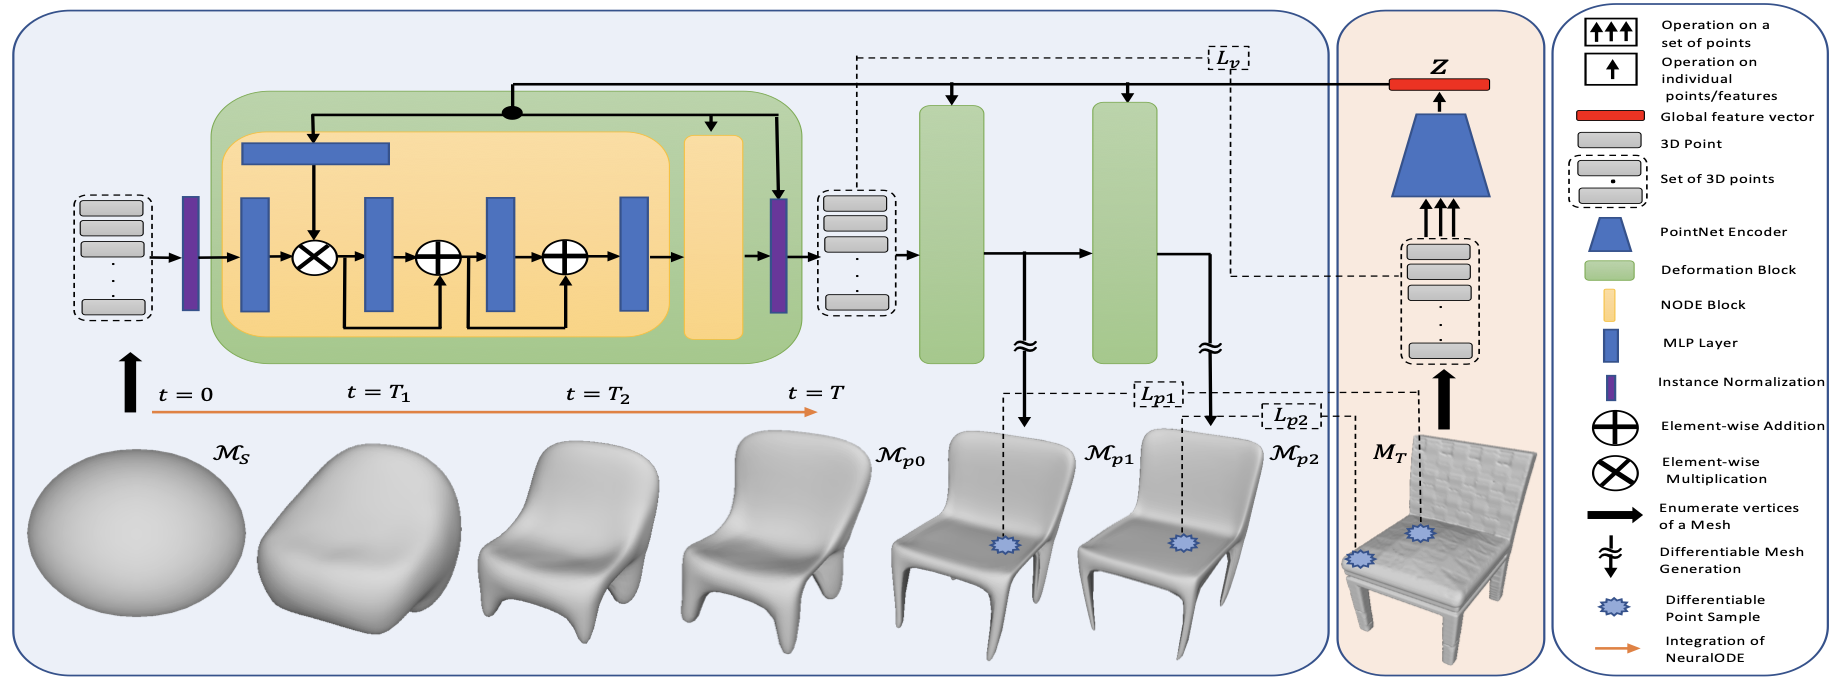

Above picture shows the compete pipeline of Neual Mesh Flow. Given a shape/point cloud, we sample 2562 points from it and feed them to a PointNet encoder which extracts the shape embedding _z_. Vertices of the initial template sphere are point-wise fed to three successive deformation blocks each of which consists of two NODE blocks and an instance normalization layer. This way we perform refinements leading to final mesh predictions. Note that we use a lightweight image to point cloud regressor for SVR task.

The following is code used to implement this pipeline. Please refer to our paper for more details and our Github repo [To be released] to find complete code used in this work.

In [5]:
import pandas as pd

In [6]:
# Load the required libraries

import torch
import torch.nn as nn
import numpy as np
from torchdiffeq import odeint_adjoint as odei
#from torchdiffeq import odeint_adjoint as odeint
import torch.nn.functional as F
import torchvision.models as models
import trimesh

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'pyembree.rtcore_scene' does not match runtime version 3.7
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'pyembree.rtcore' does not match runtime version 3.7
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'pyembree.mesh_construction' does not match runtime version 3.7
  return f(*args, **kwds)


We use a PointNet encoder to extract shape embedding for a shape. We sample 2562 points from the shape/ point cloud to obtain this embedding.

Alternatively, when given an image, we use a lightweight point predictor to get a sparse point cloud which is then fed to the PointNet encoder. 

In [7]:
class Encoder(nn.Module):
    '''
    PointNet Encoder by Qi. et.al
    '''
    def __init__(self, zdim, input_dim=3):
        super(Encoder, self).__init__()
        
        self.zdim = zdim
        self.conv1 = nn.Conv1d(input_dim, 128, 1)
        self.conv2 = nn.Conv1d(128, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.conv4 = nn.Conv1d(256, zdim, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(zdim)

        self.fc1 = nn.Linear(zdim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, zdim)
        

    def forward(self, x):
        '''
        Input: Nx#ptsx3
        Output: Nxzdim
        '''
        x = x.transpose(1, 2)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.bn4(self.conv4(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, self.zdim)

        
        ms = F.relu(self.fc_bn1(self.fc1(x)))
        ms = F.relu(self.fc_bn2(self.fc2(ms)))
        ms = self.fc3(ms)

        return ms

class PointsSVR(nn.Module):
    '''
    To allow single-view reconstruction. We estimate a sparse point cloud from the input image which is then fed to NMF pipeline.
    Refer Section 3 (Implementation details)
    '''
    
    def __init__(self):
        super(PointsSVR, self).__init__()
        '''
        Initialization
        '''
        # We use a pretrained resent18 for encoding images.
        self.encoder = models.resnet.resnet18(pretrained=True).float()
        
        # Decoder yields a point cloud with 1024 points
        self.decoder = nn.Sequential(nn.Linear(1000,2000),nn.ReLU(),
                                     nn.Linear(2000,2000),nn.ReLU(),
                                     nn.Linear(2000,1024*3))
        
    def forward(self, img):
        '''
        img: Bx3xKxK input tensor
        '''
        batch_size = img.shape[0]
        assert img.device != 0, print(" Input is on CPU")
        
        code = self.encoder(img).unsqueeze(1)
        shape = self.decoder(code).reshape(batch_size,-1,3)
        
        # Center the point cloud
        shape = shape - torch.mean(shape, axis=1, keepdim=True)
        return shape


The diffeomorphic flow is learned by means of a dynamics function f(x,t). We solve the IVP defined as dh(x,t)/dt = f(x,t) where for a given location (t) on point (x) trajectory, it returns the direction of 'flow'. 

In [8]:
class ODEFunc(nn.Module):
    '''
    This refers to the dynamics function f(x,t) in a IVP defined as dh(x,t)/dt = f(x,t). 
    For a given location (t) on point (x) trajectory, it returns the direction of 'flow'.
    Refer to Section 3 (Dynamics Equation) in the paper for details. 
    '''
    def __init__(self, num_hidden = 512, latent_len = 512):
        '''
        Initialization. 
        num_hidden: number of nodes in a hidden layer
        latent_len: size of the latent code being used
        '''
        
        super(ODEFunc, self).__init__()
        
        self.l1 = nn.Linear(3, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_hidden)   
        self.l3 = nn.Linear(num_hidden, num_hidden)
        self.l4 = nn.Linear(num_hidden, 3)
        
        self.cond = nn.Linear(latent_len, num_hidden) 

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
        self.nfe = 0
        self.zeros = torch.zeros((1, 1, latent_len))
        self.latent_dyn_zeros=None
#         self.tw = nn.Linear(1, num_hidden)
        
    def forward(self, t, xz):
        '''
        t: Torch tensor of shape (1,) 
        xz: Torch tensor of shape (N, #pts, 3+zdim). Along dimension 2, the point and shape embeddings are concatenated. 
        
        **NOTE**
        For the uniqueness property to hold, a single dynamics function (operating in 3D) must be used to compute 
        trajectories pertaining to points of a single shape. 
        
        Here, the shape encoding (same for all points of a shape) is used to choose a function which is applied over all the shape points.
        Hence, even though the input xz appears to be a 3+zdim dimensional state, the ODE is still restricted to a 3D state-space. 
        The concatenation is purely to make programming simpler without affecting the underlying theory. 
        
        '''
        point_features = self.relu(self.l1((xz[...,:3]))) # Extract point features Nx#ptsx3 -> Nx#ptsx512
        shape_features = self.tanh(self.cond(xz[...,3:]))  # Extract shape features Nx#ptsxzdim -> Nx#ptsx512
        
        point_shape_features = point_features*shape_features  # Compute point-shape features by elementwise multiplication
        # [Insight :]  Conditioning is critical to allow for several shapes getting learned by same NeuralODE. 
        #              Note that under current formulation, all points belonging to a shape share a common dynamics function.
        
        # Two residual blocks
        point_shape_features = self.relu(self.l2(point_shape_features)) + point_shape_features
        point_shape_features = self.relu(self.l3(point_shape_features)) + point_shape_features
        # [Insight :] Using less residual blocks leads to drop in performance
        #             while more residual blocks make model heavy and training slow due to more complex trajectories being learned.
        
        dyns_x_t = self.tanh(self.l4(point_shape_features)) #Computed dynamics of point x at time t
        # [Insight :] We specifically choose a tanh activation to get maximum expressivity as observed by He, et.al and Massaroli, et.al
        
        self.nfe+=1  #To check #ode evaluations
        
        # To prevent updating of latent codes during ODESolver calls, we simply make their dynamics all zeros. 
        if self.latent_dyn_zeros is None or self.latent_dyn_zeros.shape[0] != dyns_x_t.shape[0]:
            self.latent_dyn_zeros = self.zeros.repeat(dyns_x_t.shape[0],dyns_x_t.shape[1],1).type_as(dyns_x_t)  
        
        return torch.cat([dyns_x_t, self.latent_dyn_zeros], dim=2) # output is therefore like [dyn_x, dyn_y, dyn_z, 0,0..,0] for a point

The above dynamics equation is solved by an ODE Solver which we call a NODE block. This utilizes the solver written by Chen et.al. for their NeuralODE paper and allows gradients to propagate through the solver. 

In [9]:
class NODEBlock(nn.Module):
    '''
    Function to solve an IVP defined as dh(x,t)/dt = f(x,t). 
    We use the differentiable ODE Solver by Chen et.al used in their NeuralODE paper.
    '''
    def __init__(self, odefunc, tol):
        '''
        Initialization. 
        odefunc: The dynamics function to be used for solving IVP
        tol: tolerance of the ODESolver
        '''
        super(NODEBlock, self).__init__()
        self.odefunc = odefunc
        self.cost = 0
        self.rtol = tol
        self.atol = tol
        
    def forward(self, x, time):
        '''
        Solves the ODE in the forward time. 
        '''
        self.odefunc.nfe = 0  #To check #ode evaluations
        self.forward_time = torch.tensor([0, time]).float().type_as(x)  # Time of integration (must be monotinically increasing!)
        # Solve the ODE with initial condition x and interval time.
        out = odei(self.odefunc.to(x), x, self.forward_time, rtol = self.rtol, atol = self.atol)
        self.cost = self.odefunc.nfe  # Number of evaluations it took to solve it
        return out[1] 
    
    def invert(self, x, time):
        '''
        Solves the ODE in the reverse time. 
        '''
        self.inverse_time = torch.tensor([time, 0]).float().type_as(x)
        out = odei(self.odefunc, x, self.inverse_time, rtol = self.rtol, atol = self.atol)
        self.cost = self.odefunc.nfe
        return out[1]

Two NODE blocks are combined together to form a Deformation block. Note that in this implementation we applying the instance normalization inside the NeuralMeshFlow class after passing points through the deformation block. 

In [10]:
class DeformBlock(nn.Module):
    '''
    A single DeformBlock is made up of two NODE Blocks. Refer secion 3 (Overall Architecture)
    '''
    def __init__(self, time=0.2, num_hidden = 512, latent_len = 512, tol = 1e-5):
        super(DeformBlock, self).__init__()
        '''
        Initialization.
        time: some number 0-1
        num_hidden: Number of hidden nodes in the MLP of dynamics
        latent_len: Length of shape embeddings
        tol: tolerance of the ODE Solver
        '''
        
        # Two NODE Blocks
        self.l1 = NODEBlock(ODEFunc(num_hidden, latent_len), tol = tol)
        self.l2 = NODEBlock(ODEFunc(num_hidden, latent_len), tol = tol)
        
        self.time = time
        
    def forward_(self, x, code, time=None):
        '''
        Forward flow method
        
        x: BxNx3 input tensor
        code: Bxzdim tensor embedding
        time: some number 0-1
        
        y: BxNx3 output tensor
        '''
        
        if time is None:
            time=self.time
            
        xz = torch.cat([x, code.repeat(1,x.shape[1],1)],dim=2)
        # Note: To enable condioned flows, we concatenate points with their corresponding shape embeddings. 
        #       Refer to code comments in ODEFunc.forward() for more details about this choice.

        x = self.l1(xz, time)
        x = self.l2(x, time)
        
        y = x[...,:3]  # output the corresponding 'flown' points.
        return y
    
    def backward_(self, x, code, time=None):
        '''
        Backward flow method
        
        x: BxNx3 input tensor
        code: Bxzdim tensor embedding
        time: some number 0-1
        
        y: BxNx3 output tensor
        
        **NOTE** We do not use this method in the main NMF pipeline, but may come handy for things like inverting the NMF!
        
        '''
        if time is None:
            time=self.time
            
        xz = torch.cat([x, code.repeat(1,x.shape[1],1)],dim=2)
        # Note: To enable condioned flows, we concatenate points with their corresponding shape embeddings. 
        #       Refer to code comments in ODEFunc.forward() for more details about this choice.

        x = self.l2.invert(xz, time)
        x = self.l1.invert(x, time)
        
        y = x[...,:3]
        
        return y
    
    def forward(self, code, x, y=None, time=None):
        '''
        code: Bxzdim tensor embedding
        x: BxNx3 input tensor
        y: BxNx3 output tensor
        time: some number 0-1
        '''
        
        # Calculate forward flow
        pred_y = self.forward_(x,code,time)
        
        
        if y is not None:
            # Calculate backward flow if required
            pred_x = self.backward_(y,code,time)
            return pred_y, pred_x
        
        return pred_y, None

We found that instance normalization is extremely important to make NMF work for a wide range of object categories. This essentially learns to anisotropically scale NODE predictions to match the ground truth. This separates the task of learning shape attributes from that of shape variances. 

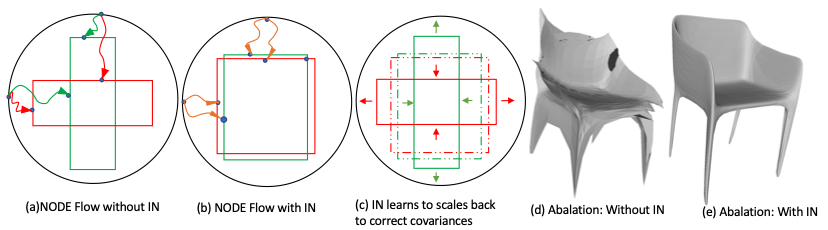

In [11]:
class InstanceNorm(nn.Module):
    '''
    Instance Normalization. Refer Section 3 in paper (Instance Normalization) for more details and Fig 5 for visual intuition.
    This is crucial for cross-category training.
    '''
    def __init__(self, zdim):
        super(InstanceNorm, self).__init__()
        '''
        Initialization.
        '''
        self.norm = nn.Sequential(nn.Linear(zdim, 256), nn.ReLU(), nn.Linear(256, 3), nn.Sigmoid()).float()
        
    def forward(self, input, code):
        '''
        input: point cloud of shape BxNx3
        code: shape embedding of shape Bx1xzdim
        '''
        centered_input = input - torch.mean(input, axis=1, keepdim=True)   # Center the point cloud
        centered_input = centered_input*(1-self.norm(code))    # anisotropic scaling the point cloud w.r.t. the shape embedding
        
        return centered_input

Now comes the main Neural Mesh Flow class. Given an image or a point cloud, we extract the shape embedding and then pass it thorough three successive deformation blocks. We additionally apply an instance normalization layer after each pair of NODE blocks to facilitate cross-category training. 

In [12]:
'''
The following is the official Pytorch implementation of Neural Mesh Flow.
'''    
class NeuralMeshFlow(nn.Module):
    '''
    Implementation of the Neural Mesh Flow pipeline. Refer Section 3 in the paper for more details.
    '''
    def __init__(self, encoder_type = 'image', PATH_svr = './data/nmf_svr', zdim=1000, time=0.2, tol = 1e-5):
        super(NeuralMeshFlow, self).__init__()
        '''
        Initialization
        encoder_type: 'image' or 'point' for SVR and shape completion tasks repectively
        PATH_svr: model file for trained PointsSVR
        zdim: length of latent embedding
        time: some number 0-1
        tol: tolerance of ODESolver.
        '''
        
        '''
        **** NOTE on design choices  ******
        
        zdim : We did not observe much benefit of increased latent embedding size (i.e. >1000) and it simply increases memory requirement
        time : time of integration (set to 0.2) is chosen since it is long enough for effective integration but not too large to cause complex dynamics
        tol  : A lower tol is always better but comes at a cost of inference time. Refer to ablation in Supplementary for this.

        '''

        print("Neural Mesh Flow with {} length embedding initialized".format(zdim))
        
        # Three deform blocks to cause successive refinements. Refer Section 3 (Overal architecture)
        self.db1 = DeformBlock(time, num_hidden = 512, latent_len = zdim, tol=tol)
        self.db2 = DeformBlock(time, num_hidden = 512, latent_len = zdim, tol=tol)
        self.db3 = DeformBlock(time, num_hidden = 512, latent_len = zdim, tol=tol)
        
        # Template spheres for training/testing. 
        
        # [Insight :] While trainig with smaller (#vertices) sphere is faster, inference with larger sphere is more accurate. 
        # Choosing spheres with even lower vertices can cause drop in performance due to unstable optimization. 
        # Using #vertices >2520 doesn't yeild much benefit and takes more training time.
        
        # These spheres are generated using Pymesh library : pymesh.generate_icosphere(radius=1, center=(0,0,0), refinement_order=3 or 4)
        
        self.sph_train = trimesh.load('./data/mypymeshsph_3.obj')  # Unit sphere with 622 vertices
        self.sph_test  = trimesh.load('./data/mypymeshsph_4.obj')   # Unit sphere with 2520 vertices
        
        # Convert faces and vertices to torch. Face information will later be used for generating differentiable meshes.
        self.f = [torch.from_numpy(self.sph_train.faces).int(), torch.from_numpy(self.sph_test.faces).int()] # Faces
        self.v = [torch.from_numpy(self.sph_train.vertices), torch.from_numpy(self.sph_test.vertices)]       # Vertices
        
        self.time = time  
        
        # For SVR task, we require an additional image encoder. 
        if encoder_type == 'image':
            print("Choosing image encoder")
            
            pointmodel = nn.DataParallel(PointsSVR()).float()  # Use PointsSVR to get point cloud initialization
            pointmodel.load_state_dict(torch.load(PATH_svr))  # Load pretrained weights for PointsSVR
            self.svr = pointmodel
            self.encoder = Encoder(zdim).float()            # Initialize PointNet encoder 
        
        # For shape completion, we require only points encoder.
        elif encoder_type == 'point':
            print("Choosing Point Encoder")
            self.encoder = Encoder(zdim).float()  # Initialize PointNet encoder
        else:
            print(" Invalid choice of encoder!! ")

        # Initialize InstanceNorm layers
        self.norm0 = InstanceNorm(zdim)
        self.norm1 = InstanceNorm(zdim)
        self.norm2 = InstanceNorm(zdim)
        self.norm3 = InstanceNorm(zdim)
        
    def get_code_(self, x):
        '''
        Fetch the shape embeddings for point clouds in x
        x: BxNx3 input tensor
        code: Bx1xzdim tensor embedding
        '''
        code = self.encoder(x)
        code = code.unsqueeze(1)
        
        return code

    def forward(self, input, time=None):
        '''
        input: BxNx3 tensor
        pred_y1: BxNx3 tensor; vertices after first deformation block
        pred_y2: BxNx3 tensor; vertices after second deformation block
        pred_y3: BxNx3 tensor; vertices after third deformation block
        face: BxKx3; faces to be used for constructing differentiable meshes
        '''
        batch_size = input.shape[0]
        assert input.device != 0, print(" Input is on CPU")
        
        if len(input.shape) == 4:
            # Input is an image
            # First predict a sparse point cloud from this image
            pts_init = self.svr(input).type_as(input)
            # Center this point cloud
            pts_init = pts_init - torch.mean(pts_init, axis=1, keepdim=True)
            # Now get the shape embedding from this point cloud
            code = self.get_code_(pts_init).type_as(input)
        else:
            # Input is a (centered) point cloud. Directly compute its embedding
            code = self.get_code_(input).type_as(input) # Get latent code using point cloud at native resolution
                  
        # Use smaller sphere (622 vertices) for training otherwise use a larger sphere (2520 vertices) for testing
        sphidx = 0 if self.training else 1
        sph = self.v[sphidx].unsqueeze(0).repeat(batch_size,1,1).type_as(input)
        face = self.f[sphidx].unsqueeze(0).repeat(batch_size,1,1).type_as(input)
        
        # Apply instance norm to input sphere
        sph = self.norm0(sph, code)
        
        # First Deform Block computation and its instance norm
        pred_y1, _ = self.db1(code, sph, None, time)
        pred_y1 = self.norm1(pred_y1, code)
        
        # Second Deform Block computation and its instance norm
        pred_y2, _ = self.db2(code, pred_y1, None, time)
        pred_y2 = self.norm2(pred_y2, code)
        
        # Third Deform Block computation and its instance norm
        pred_y3, _ = self.db3(code, pred_y2, None, time)
        pred_y3 = self.norm3(pred_y3, code)
        
        return pred_y1, pred_y2, pred_y3, face

Let's try this on a single view mesh reconstruction task. First, we will set up the NMF to take in images and load pretrained weights. 

In [13]:
#@title Some code for I/O
import imageio
import matplotlib.pyplot as plt

def read_color_image(filename):
    return np.array(imageio.imread(filename))[...,:3]


def normalize_imagenet(x):
    ''' Normalize input images according to ImageNet standards.
    Args:
        x (tensor): input images
    '''
    x = x.clone()
    x[:, 0] = (x[:, 0] - 0.485) / 0.229
    x[:, 1] = (x[:, 1] - 0.456) / 0.224
    x[:, 2] = (x[:, 2] - 0.406) / 0.225
    return x 

def load_partial_pretrained(mymodel, path):
    '''
    Helps to load pretrained weights of model from a path.
    mymodel: model to be used
    path: path to the pretrained weights
    *** NOTE ***
    Sometimes this function ends up not loading any wieghts because of the mismatch in the weight-keys of model and pretrained weights. So if you encounter anything like that make sure to print the respective keys and match them!
    '''
    pretrained_dict = torch.load(path)
    model_dict = mymodel.state_dict()

    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    model_dict.update(pretrained_dict) 
    mymodel.load_state_dict(model_dict)

In [14]:
encoder_type = 'image'   # Set encoder type to images
model = nn.DataParallel(NeuralMeshFlow(encoder_type = encoder_type)).cuda()   # Initialize NMF model
load_partial_pretrained(model,'./data/nmf_ae')             # Load pretrained weights 
model.eval();      # Set NMF to evaluation mode

Neural Mesh Flow with 1000 length embedding initialized
Choosing image encoder


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [15]:
!ls data/img   # List of sample images

car.png  chair.png  plane.png  sofa.png  table.png  toiletseat.png


Now choose one image from the above.

In [16]:
I  = read_color_image('./data/img/chair.png') 

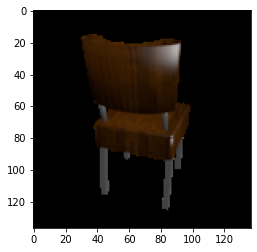

In [17]:
plt.imshow(I)
plt.show()

In [18]:
# Prepare Image to be fed into NMF

I = I.astype(np.float64)/255.0   # Convert image (0-255, int) to (0-1, float)
I = torch.from_numpy(I)
I = normalize_imagenet(I).transpose(0,2).float().unsqueeze(0).cuda()   # Normalize w.r.t. Imagenet stats and (H,W,3) -> (3,H,W) for adequate training

## Let's run the NMF !

In [19]:
_,_,pred, face = model(I)

In [20]:
# Export predicted mesh using trimesh

vertices = pred[0,...].detach().cpu().numpy()
faces = face[0,...].detach().cpu().numpy()
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

We can visualize the predicted mesh below. Notice that NMF predicts meshes that are manifold and therefore do not suffer from self-intersections, etc. This is extremely useful for physically based tasks like simulation, rendering and 3D printing.

In [21]:
mesh.show()

In [22]:
mesh.export('mymesh.obj');  # Save mesh to local drive. You would need to mount your gdrive inorder to download this. 